In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from cmdstanpy import CmdStanModel
from baynes.plotter import FitPlotter
from baynes.model_utils import get_stan_file
from baynes.analysis import *
from baynes.probability import hdi
import pandas as pd
from scipy import stats
import cmdstanpy
import logging
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)
sns.set_style('ticks')
#sns.set_palette('colorblind')
sns.set_context("notebook", font_scale=1.6)
plt.rc("axes.spines", top=False, right=False)
import matplotlib as mpl
from matplotlib import cycler
colors = ["#e60049", "#0bb4ff", "#50e991", "#e6d800", "#9b19f5", "#ffa300", "#dc0ab4", "#b3d4ff", "#00bfa0"][4:8]#['#1b9e77','#e7298a','#d95f02','#7570b3','#66a61e','#e6ab02','#a6761d','#666666']
mpl.rcParams['axes.prop_cycle'] = cycler('color',colors)

# Example 1: fit of a poissonian process
### Generate the data

- mean of data:  6.268
- sd of data:  2.4527894324625588


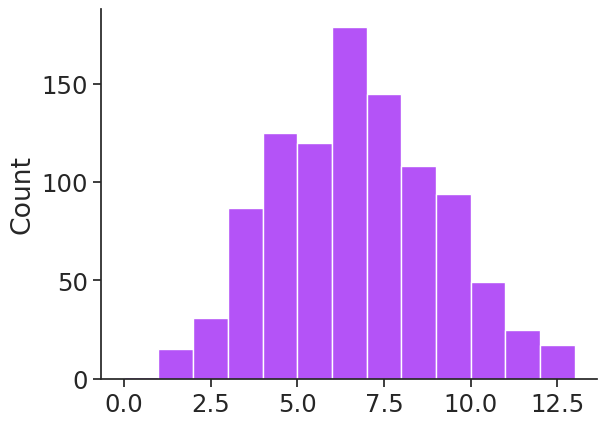

In [68]:
N=1000
lambda_true = 6.3
events = np.random.poisson(lambda_true, N)

data_mean = np.mean(events)
data_sd = np.std(events)
print('- mean of data: ', data_mean)
print('- sd of data: ', data_sd)
bins = np.arange(min(events), max(events))
sns.histplot(events, bins=bins)
sns.despine()

### Compile and print the STAN model


In [69]:
stan_file = get_stan_file('poisson.stan')
model = CmdStanModel(stan_file=stan_file,
                     cpp_options={'STAN_THREADS': True, 'jN': 4})
print(model.code())

Found .stan file  /home/pietro/work/TESI/baynes/stan/models/poisson/poisson.stan
data {
  int<lower=0> N;
  array[N] int y;
  real alpha;
  real beta;
  int<lower=0, upper=1> prior;
}

parameters {
  real<lower=0> lambda;
}

model {
  lambda ~ gamma(alpha, beta);
  if (prior == 0){
    y ~ poisson(lambda);
  }
}

generated quantities {
  array[N] int<lower = 0> y_rep = poisson_rng(rep_array(lambda, N));
  real<lower = 0> mean_y_rep = mean(to_vector(y_rep));
  real<lower = 0> sd_y_rep = sd(to_vector(y_rep));
}


In [70]:
df=pd.DataFrame()
prior_var=10
data = {'N': len(events), 'y': events, 'alpha': 5, 'beta': 1, 'prior': 0}

plot = FitPlotter(fig_scale=6,output_dir="/home/pietro/work/TESI/thesis/figures/ch2/poisson/", output_format='.pdf')
post=[]
mus= np.linspace(1, 51, 10)

Ns=[50, 100, 200, 500]
for N in Ns:
    events = np.random.poisson(lambda_true, N)
    data = {'N': len(events), 'y': events, 'alpha': 5, 'beta': 1, 'prior': 0}
    dN = pd.DataFrame()
    for mu in mus:
        data['beta'] = mu/prior_var
        data['alpha'] = mu**2/prior_var
    
        fit = model.sample(data,
                           chains=24,
                           iter_warmup=200,
                           iter_sampling=300,
                           save_warmup=False,
                           show_progress=False)
       # plot.add_fit(fit, fit_title= str(mu))
       # post.append(fit.stan_variable('lambda'))
        
        dfit = fit.draws_pd(['lambda'])
      #  print(hdi(dfit.to_numpy().flatten()))
        dfit['prior mean'] = mu
       # print(dfit)
        dN = pd.concat([dN, dfit])
    dN['N'] = N
    df = pd.concat([df, dN])

#plot.get_fit_titles()
#plot.ridgeplot(fit_titles='all')

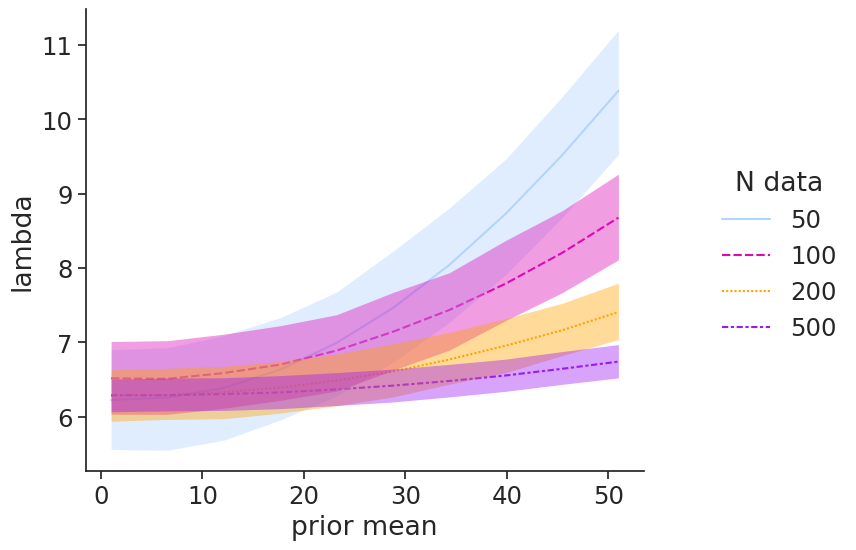

In [71]:
ax = plot.new_figure('sens').subplots()
sns.lineplot(df, x='prior mean', y='lambda', hue='N', errorbar=hdi, ax=ax, palette=colors[::-1], zorder=0, err_kws={'alpha':0.4, 'lw':0}, style='N')
#sns.lineplot(df, x='prior mean', y='lambda', hue='N', errorbar=None, ax=ax, palette=colors[::-1])

ax.legend(bbox_to_anchor=(1.1, 0.7), facecolor='white', edgecolor='white', title='N data')

In [72]:
plot.save_figures()

In [73]:
plot.ridgeplot(fit_titles=plot.get_fit_titles('mu'), height=0.7)

AttributeError: 'FitPlotter' object has no attribute 'stan_variables'

In [ ]:
plot.draws_df(fit_titles=plot.get_fit_titles('ad'), parameters='lambda').melt()

In [ ]:
sns.lineplot(plot.draws_df(fit_titles='all', parameters=['lambda']), x='fit', y='lambda')

In [ ]:
plot.draws_df(fit_titles='all', parameters=['lambda'])

In [ ]:
sns.lineplot({'x': mus*len(post), 'y': post}, y='y')

In [ ]:
np.array(post).shape

In [ ]:
plt.hist(np.random.gamma(100, 1, 10000), bins=50)

In [ ]:
data = {'N': len(events), 'y': events, 'alpha': 5, 'beta': 1, 'prior': 0}

plot = FitPlotter()
for mu in [1, 10, 20, 40, 60, 80, 100]:
    data['alpha'] = mu
    fit = model.sample(data,
                       chains=4,
                       iter_warmup=200,
                       iter_sampling=300,
                       save_warmup=False,
                       show_progress=False)
    plot.add_fit(fit, fit_title= "$\\alpha=$" + str(mu))
plot.get_fit_titles()
plot.ridgeplot(fit_titles=plot.get_fit_titles('alpha'))

In [ ]:
list(plot.fits.keys())

In [ ]:
N=100
events = np.random.poisson(lambda_true, N)
data = {'N': len(events), 'y': events, 'alpha': 3, 'beta': 0.1, 'prior': 1}
sampler_kwargs={
    'chains': 4,
    'iter_warmup': 500,
    'iter_sampling': 2000,
    'save_warmup': True, 
}
fplot = FitPlotter(fig_scale=7)
fit = standard_analysis(model, data, fplot, sampler_kwargs=sampler_kwargs, data_key='y', rep_key='y_rep', lines=True, legend=False, n_bins=len(bins))

fit_prior = fplot.fits['fit_prior']
joint = sns.jointplot({'posterior': fit.stan_variable('lambda'), 'prior': fit_prior.stan_variable('lambda')}, x='prior', y='posterior', kind='reg', scatter_kws={'s':0.1}, robust=True)
fig = fplot.new_figure('static', joint.figure)

In [ ]:
joint = sns.jointplot(fit.draws_pd(['lambda', 'sd_y_rep']), x='lambda', y='sd_y_rep', kind='reg', scatter_kws={'s':0.1})
joint = sns.jointplot(fit.draws_pd(['lambda', 'mean_y_rep']), x='lambda', y='mean_y_rep', kind='reg', scatter_kws={'s':0.1})

fig = fplot.new_figure('static', joint.figure)

In [ ]:
fplot.pair_grid(['lambda', 'sd_y_rep', 'mean_y_rep'])

In [ ]:
fplot.draws_df(fit_titles='all', parameters=['lambda', 'mean_y_rep'])

In [ ]:
fit_prior = fplot.fits['fit_prior']
joint = sns.jointplot({'posterior': fit.stan_variable('lambda'), 'prior': fit_prior.stan_variable('lambda')}, x='prior', y='posterior', xlim=[0,15], kind='reg', scatter_kws={'s':0.1})
fig = fplot.new_figure('static', joint.figure)